In [133]:
'''
This notebook use a few regressors of Spark ML library to train a model
using the same data set as used in regressors.ipynb and for the same network 
prediction purpose.
'''
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import random
import numpy
import time
import math

spark_sql = SQLContext(sc)

In [134]:
%%time
''' 
Read a few million rows of observed network metrics reported by ~10k endpoints. 
Each column contains the following information of the endpoints:
'''
data = spark_sql.read.format('com.databricks.spark.csv')\
    .options(header='false', inferschema='true')\
    .load('../data/etl2M.csv' if os.path.isfile('../data/etl2M.csv')\
                              else '../data/etl2M.csv.*')\

data.count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.33 s


In [135]:
%%time
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(    # these metric are interesting
    inputCols=[
        "_c1",
        "_c2",  # 1-hr moving average of _c3
        "_c3",  # 1-min metric #1
        "_c4",  # delta of _c3
        "_c5",  # 1hr moving average of _c6
        "_c6",  # 1min metric #2
        "_c7",  # delta of _c6
        "_c8",  # 1hr moving average of _c9
        "_c9",  # 1min metric #3
        "_c10", # delta of _c9
        "_c11", # 1hr moving average of _c12
        "_c12", # 1min metric #4
        "_c13", # delta of _c12
        "_c14", # 1hr moving average of _c15
        "_c15", # 1min metric #5
        "_c16", # delta of _c15
        "_c17", # 1hr moving average of effective network throughput (= percentage of maximum)
              ],
    outputCol="indexedFeatures")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.62 ms


In [140]:
def time2str(tstart, tag):
    tsec = time.time() - tstart
    tmin = tsec // 60
    tsec = tsec %  60
    thrs = tmin // 60
    tmin = tmin %  60
    return '%s=%02d:%02d:%02d' % (tag, thrs, tmin, tsec)

def plot_chart(truths, predictions, algo_name, tuse, rmse_score):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    plt.scatter(numpy.arange(0, len(truths)),      truths,      c='b', s=2, label='ground truth') 
    plt.scatter(numpy.arange(0, len(predictions)), predictions, c='r', s=2, label='prediction')                                                                                                  
    plt.axis('tight')                                                                                                                           
    plt.legend()                                                                                                                                
    plt.title("%s: %s %s" % (algo_name, tuse, rmse_score))                                                                                                                                      
    plt.savefig("/data/tmp/spark/%s.png" % algo_name) 
    plt.grid()
    plt.show()
    plt.clf()


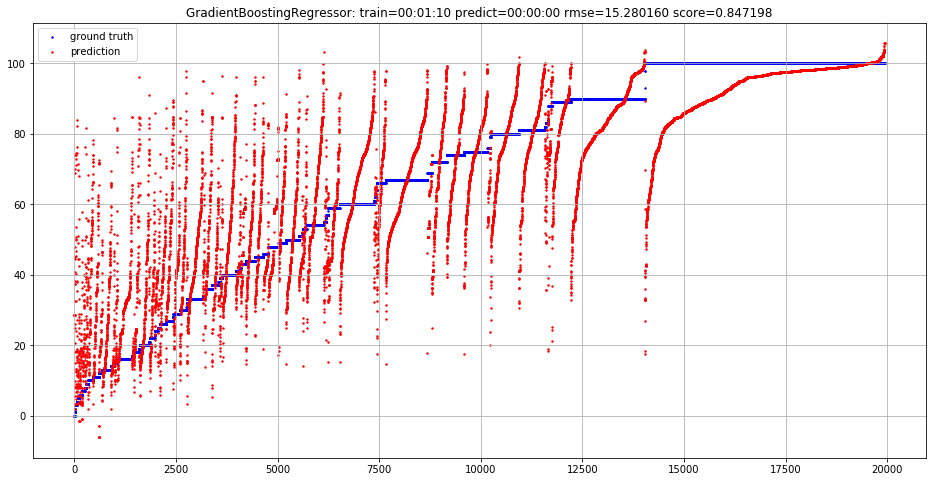

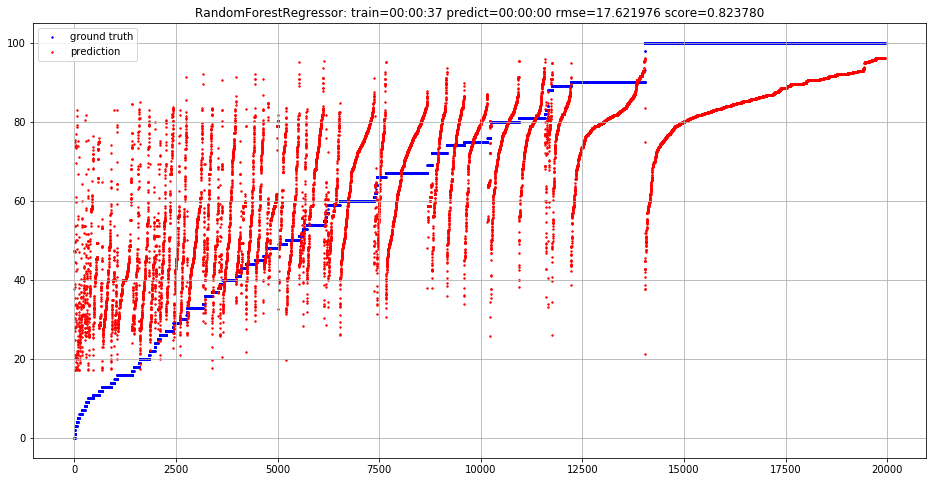

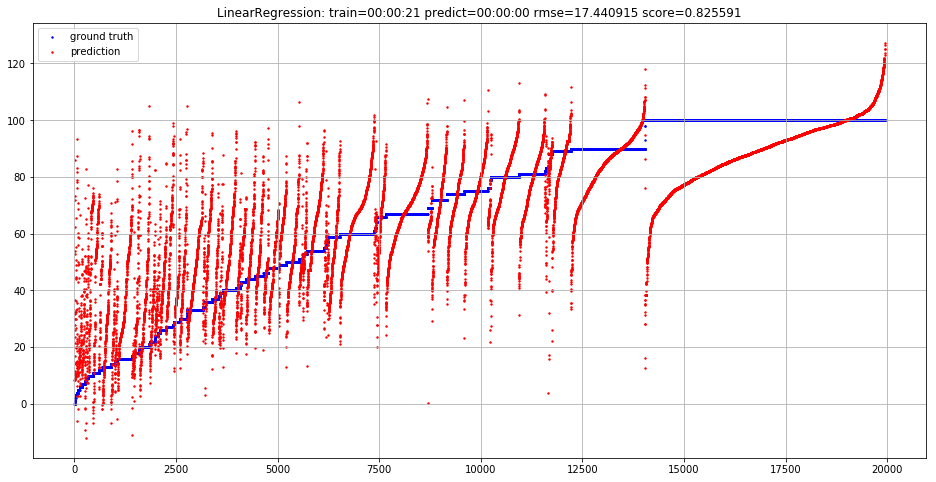

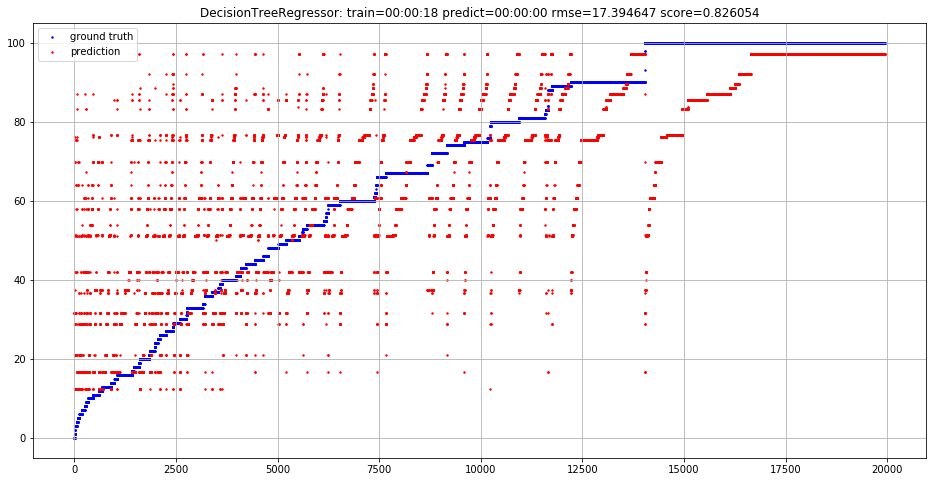

CPU times: user 7.72 s, sys: 4.5 s, total: 12.2 s
Wall time: 3min 21s


In [141]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

algorithms = {
    'LinearRegression':           LinearRegression     (featuresCol="indexedFeatures", labelCol='_c18'),
    'DecisionTreeRegressor':      DecisionTreeRegressor(featuresCol="indexedFeatures", labelCol='_c18'),
    'RandomForestRegressor':      RandomForestRegressor(featuresCol="indexedFeatures", labelCol='_c18'),
    'GradientBoostingRegressor':  GBTRegressor         (featuresCol="indexedFeatures", labelCol='_c18'),
    }                                  

(trainingData, testData) = data.randomSplit([0.99, 0.01])

# what a evaluator
evaluator = RegressionEvaluator(labelCol="_c18", predictionCol="prediction", metricName="rmse")

for algo_name in algorithms:
    algorithm = algorithms[algo_name]

    # what a pipeline
    pipeline = Pipeline(stages = [assembler, algorithm])

    # train
    tstart = time.time()
    model = pipeline.fit(trainingData)
    tuse = time2str(tstart, 'train')
    
    # predict
    tstart = time.time()
    predictions = model.transform(testData)
    tuse = tuse + " " + time2str(tstart, 'predict')
    
    # evalurate
    rmse = evaluator.evaluate(predictions)
    rmse_score = 'rmse={0:f}'.format(rmse)
    rmse_score += ' score={0:f}'.format((100 - rmse) / 100)

    # with spark particularly, transforming dataframe to numpy array is necessary
    # otherwise, zip-sort below produces unexpected data type !!
    truths      = testData   .select('_c18')
    predictions = predictions.select('prediction')
    truths      = numpy.array(truths     .collect())
    predictions = numpy.array(predictions.collect())
    
    # plot
    truths, predictions = zip(*sorted(zip(truths, predictions)))
    plot_chart(truths, predictions, algo_name, tuse, rmse_score)
    
    # Save and load model
    model.save(sc, "/data/tmp/spark/%s" % algo_name)
    # sameModel = RandomForestModel.load(sc, "/data/tmp/spark/%s" % algo_name)
